# Custom State

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from typing import Annotated, TypedDict

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]
    ask_human: bool

In [3]:
from langchain_core.tools import tool

@tool
def request_assistance():
    """
    IMMEDIATELY escalate to a human agent. You MUST use this tool when:
    - User mentions: billing, refund, cancel, account, payment, subscription
    - User explicitly asks to talk to a human/person/agent
    - The user is frustrated or angry
    
    Do NOT try to search or solve these issues yourself - escalate immediately.
    """
    return ""

In [4]:
import os

tool = TavilySearchResults(max_results=2)
tools = [tool, request_assistance]
llm = ChatOpenAI(
    model="deepseek-chat",
    api_key=os.getenv("DEEPSEEK_API_KEY"),
    base_url="https://api.deepseek.com",
    temperature=0
)
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human=False
    if response.tool_calls and response.tool_calls[0]["name"] == "request_assistance":
        ask_human=True
    return {"messages": [response], "ask_human": ask_human}

C:\Users\49172\AppData\Local\Temp\ipykernel_33512\715124610.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(max_results=2)


In [5]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

In [6]:
from langchain_core.messages import AIMessage, ToolMessage

def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )

def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        "messages": new_messages,
        "ask_human": False
    }

graph_builder.add_node("human", human_node)

In [7]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    return tools_condition(state)

graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)

In [8]:
import sqlite3

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.set_entry_point("chatbot")

conn = sqlite3.connect(":memory:", check_same_thread=False)
checkpointer = SqliteSaver(conn)

graph = graph_builder.compile(
    checkpointer=checkpointer,
    interrupt_before=["human"],
)

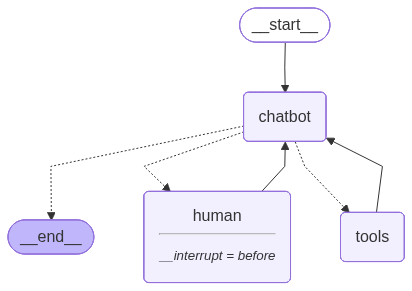

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [10]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "8"}}

input_message = HumanMessage(content="I need to speak with a real person about my billing issue")

graph.invoke({"messages": input_message}, config=config)


{'messages': [HumanMessage(content='I need to speak with a real person about my billing issue', additional_kwargs={}, response_metadata={}, id='925e691e-59fc-482c-9c82-786347b26823'),
  AIMessage(content="I understand you need to speak with a real person about your billing issue. I'll connect you with a human agent who can help you with this matter.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 444, 'total_tokens': 502, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 384}, 'prompt_cache_hit_tokens': 384, 'prompt_cache_miss_tokens': 60}, 'model_provider': 'openai', 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': 'a0927cdf-b805-4f8a-bba7-6a9c3a7f2f3c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b023d-7869-7ba2-8d98-6b894283f3ee-0', tool_calls=[{'name': 'request_assistance', 'args': {}, 'id': 'call_

In [11]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

In [12]:
# ===========================================
# Test Cases for LangSmith Tracing
# ===========================================
# Run these with LangSmith enabled to see traces at https://smith.langchain.com

# Test Case 1: Should trigger request_assistance (billing issue)
config = {"configurable": {"thread_id": "test_1"}}
input_message = HumanMessage(content="I was charged twice for my subscription, I need a refund immediately!")
result = graph.invoke({"messages": input_message}, config=config)
print(f"Test 1 - ask_human: {result['ask_human']}")
print(f"Tool called: {result['messages'][-1].tool_calls[0]['name'] if result['messages'][-1].tool_calls else 'None'}")

Test 1 - ask_human: True
Tool called: request_assistance


In [13]:
# Test Case 2: Should trigger request_assistance (explicit human request)
config = {"configurable": {"thread_id": "test_2"}}
input_message = HumanMessage(content="Stop! I don't want AI help. Transfer me to a human agent right now.")
result = graph.invoke({"messages": input_message}, config=config)
print(f"Test 2 - ask_human: {result['ask_human']}")
print(f"Tool called: {result['messages'][-1].tool_calls[0]['name'] if result['messages'][-1].tool_calls else 'None'}")

Test 2 - ask_human: True
Tool called: request_assistance


In [14]:
# Test Case 3: Should use TavilySearch (factual question)
config = {"configurable": {"thread_id": "test_3"}}
input_message = HumanMessage(content="What is the weather like in Tokyo today?")
result = graph.invoke({"messages": input_message}, config=config)
print(f"Test 3 - ask_human: {result['ask_human']}")
print(f"Tool called: {result['messages'][-1].tool_calls[0]['name'] if result['messages'][-1].tool_calls else 'None'}")

Test 3 - ask_human: False
Tool called: None


In [15]:
# Test Case 4: Should trigger request_assistance (account deletion)
config = {"configurable": {"thread_id": "test_4"}}
input_message = HumanMessage(content="Delete my account and all my personal data permanently.")
result = graph.invoke({"messages": input_message}, config=config)
print(f"Test 4 - ask_human: {result['ask_human']}")
print(f"Tool called: {result['messages'][-1].tool_calls[0]['name'] if result['messages'][-1].tool_calls else 'None'}")

Test 4 - ask_human: False
Tool called: None


In [16]:
# Test Case 5: Should use TavilySearch (news/info) 
config = {"configurable": {"thread_id": "test_5"}}
input_message = HumanMessage(content="What are the latest AI developments in 2024?")
result = graph.invoke({"messages": input_message}, config=config)
print(f"Test 5 - ask_human: {result['ask_human']}")
print(f"Tool called: {result['messages'][-1].tool_calls[0]['name'] if result['messages'][-1].tool_calls else 'None'}")

Test 5 - ask_human: False
Tool called: None


In [17]:
# Test Case 6: Should trigger request_assistance (frustrated user)
config = {"configurable": {"thread_id": "test_6"}}
input_message = HumanMessage(content="This is ridiculous! Your service is terrible. I've been waiting for 3 days. Get me a manager!")
result = graph.invoke({"messages": input_message}, config=config)
print(f"Test 6 - ask_human: {result['ask_human']}")
print(f"Tool called: {result['messages'][-1].tool_calls[0]['name'] if result['messages'][-1].tool_calls else 'None'}")

Test 6 - ask_human: True
Tool called: request_assistance


In [22]:
snapshot = graph.get_state({"configurable": {"thread_id": "test_2"}})
snapshot.next

('human',)

In [25]:
ai_message = snapshot.values["messages"][-1]
human_response = "OK. Please leave your phone number and human support will reach you later."
tool_message = create_response(human_response, ai_message)
graph.update_state({"configurable": {"thread_id": "test_2"}}, {"messages": [tool_message]})

{'configurable': {'thread_id': 'test_2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0d4dc1-046a-64d1-8002-f1b97f97ed62'}}

In [26]:
graph.invoke(None, config={"configurable": {"thread_id": "test_2"}})

{'messages': [HumanMessage(content="Stop! I don't want AI help. Transfer me to a human agent right now.", additional_kwargs={}, response_metadata={}, id='b5a73f9f-a2ea-4ad0-802d-a9edb61d37e2'),
  AIMessage(content="I understand you want to speak with a human agent. I'll connect you with a human representative right away.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 450, 'total_tokens': 499, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 448}, 'prompt_cache_hit_tokens': 448, 'prompt_cache_miss_tokens': 2}, 'model_provider': 'openai', 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': 'db3d6841-a86e-4e14-948d-3cb0143c1abf', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b023d-9a90-7351-b36a-f1abe6571dac-0', tool_calls=[{'name': 'request_assistance', 'args': {}, 'id': 'call_00_XaH84j7GtUjTg9MgRSVuylli', 

()